In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
!wget https://www.dropbox.com/s/jsstf0deq2yo8cx/face_.png

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
def salt_n_pepper(image):
    s_vs_p = 0.5
    amount = 0.15
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
            for i in image.shape] # Select random coordinates fist from axis 0 then from axis 1 then modify using the mapping function below to make it white
    out[coords] = 255

    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper)) 
            for i in image.shape] # Select random coordinates fist from axis 0 then from axis 1 then modify using the mapping function below to make it black
    out[coords] = 0

    return out

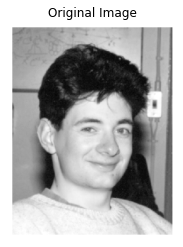

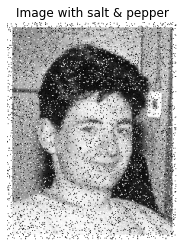

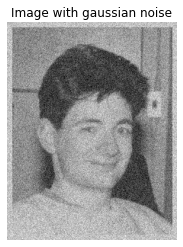

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

dpi = 50
img = cv2.imread("face_.png", 0)
width, height = img.shape
figsize = width // float(dpi), height // float(dpi)

#----------- ORIGINAL IMAGE
plt.figure(figsize=figsize)
plt.title("Original Image")
imgplot = plt.imshow(img, cmap="gray"), plt.axis("off")
plt.show()

#----------- SALT & PEPPER NOISE
img_0 = salt_n_pepper(img)
plt.figure(figsize=figsize)
plt.title("Image with salt & pepper")
imgplot = plt.imshow(img_0, cmap="gray"), plt.axis("off")
plt.show()

#----------- GAUSSIAN NOISE
noise = np.reshape(np.random.normal(0, 10, width*height), (width, height))
img_1=img+3*noise # boradcasting
plt.figure(figsize=figsize)
plt.title("Image with gaussian noise")
imgplot = plt.imshow(img_1, cmap="gray"), plt.axis("off")
plt.show()
    

In [5]:
from scipy import signal
img1 = cv2.blur(img,(5,5))
img2 = cv2.GaussianBlur(img,(5,5),0)
img3 = cv2.medianBlur(img, 5)

kernel = 2*signal.unit_impulse((5,5), 'mid') - np.ones((5,5),np.float32)/25
img4 = cv2.filter2D(img,-1,kernel)

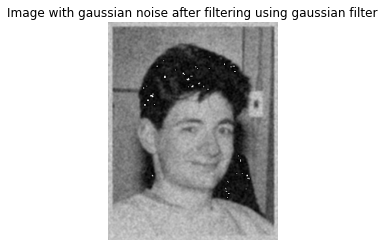

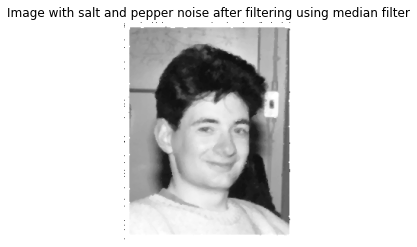

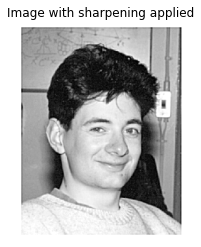

In [6]:
# Remove gaussian and salt and pepper noises from the respective images
# Plot the resulting images using Mean filter
def mean_median_kernel(image,type): # Assume only allowed filter is of size 3x3 with no padding applied
  out=np.copy(image)
  if type=='mean':
    for i in range(1,out.shape[0]-1):
      for j in range(1,out.shape[1]-1):
        val=int(np.round(np.mean(out[i-1:i+2,j-1:j+2].flatten()))) # Can change these values to be dynamic according to the filter size, using the new values of out
        out[i,j]=val
  elif type=='median':
    for i in range(1,out.shape[0]-1):
      for j in range(1,out.shape[1]-1):
        val=int(np.round(np.median(out[i-1:i+2,j-1:j+2].flatten())))
        out[i,j]=val
  return out
def gaussian_kernel(image,mu=1.5): # Assume size 3*3 with no padding
  out=np.copy(image)
  gkern1d = signal.gaussian(3, std=mu).reshape(3, 1)
  gkern2d = np.outer(gkern1d, gkern1d)
  out_conv=np.zeros((image.shape[0]-2,image.shape[1]-2))
  for i in range(0,out.shape[0]-2):
      for j in range(0,out.shape[1]-2):
        #print(out[i:i+3,j:j+3])
        #print((out[i:i+3,j:j+3]*gkern2d))
        #print(np.sum((out[i:i+3,j:j+3]*gkern2d)))
        out_conv[i,j]=np.round(np.mean((out[i:i+3,j:j+3]*gkern2d).flatten()))
  out=out_conv.astype(dtype='uint8')
  return out
plt.figure(figsize=figsize)
plt.title("Image with gaussian noise after filtering using gaussian filter")
imgplot = plt.imshow(gaussian_kernel(img_1), cmap="gray"), plt.axis("off")
plt.show()

plt.figure(figsize=figsize)
plt.title("Image with salt and pepper noise after filtering using median filter")
imgplot = plt.imshow(mean_median_kernel(img_0,type='median'), cmap="gray"), plt.axis("off")
plt.show()

plt.figure(figsize=figsize)
plt.title("Image with sharpening applied")
imgplot = plt.imshow(img4, cmap="gray"), plt.axis("off")
plt.show()

### Gaussian Pyramid

Write a code that generates gaussian pyramid for the image `face_.png`. Test against different scales and different sigmas. Visit this [link](http://www.cse.yorku.ca/~kosta/CompVis_Notes/gaussian_pyramid.pdf) for more info.

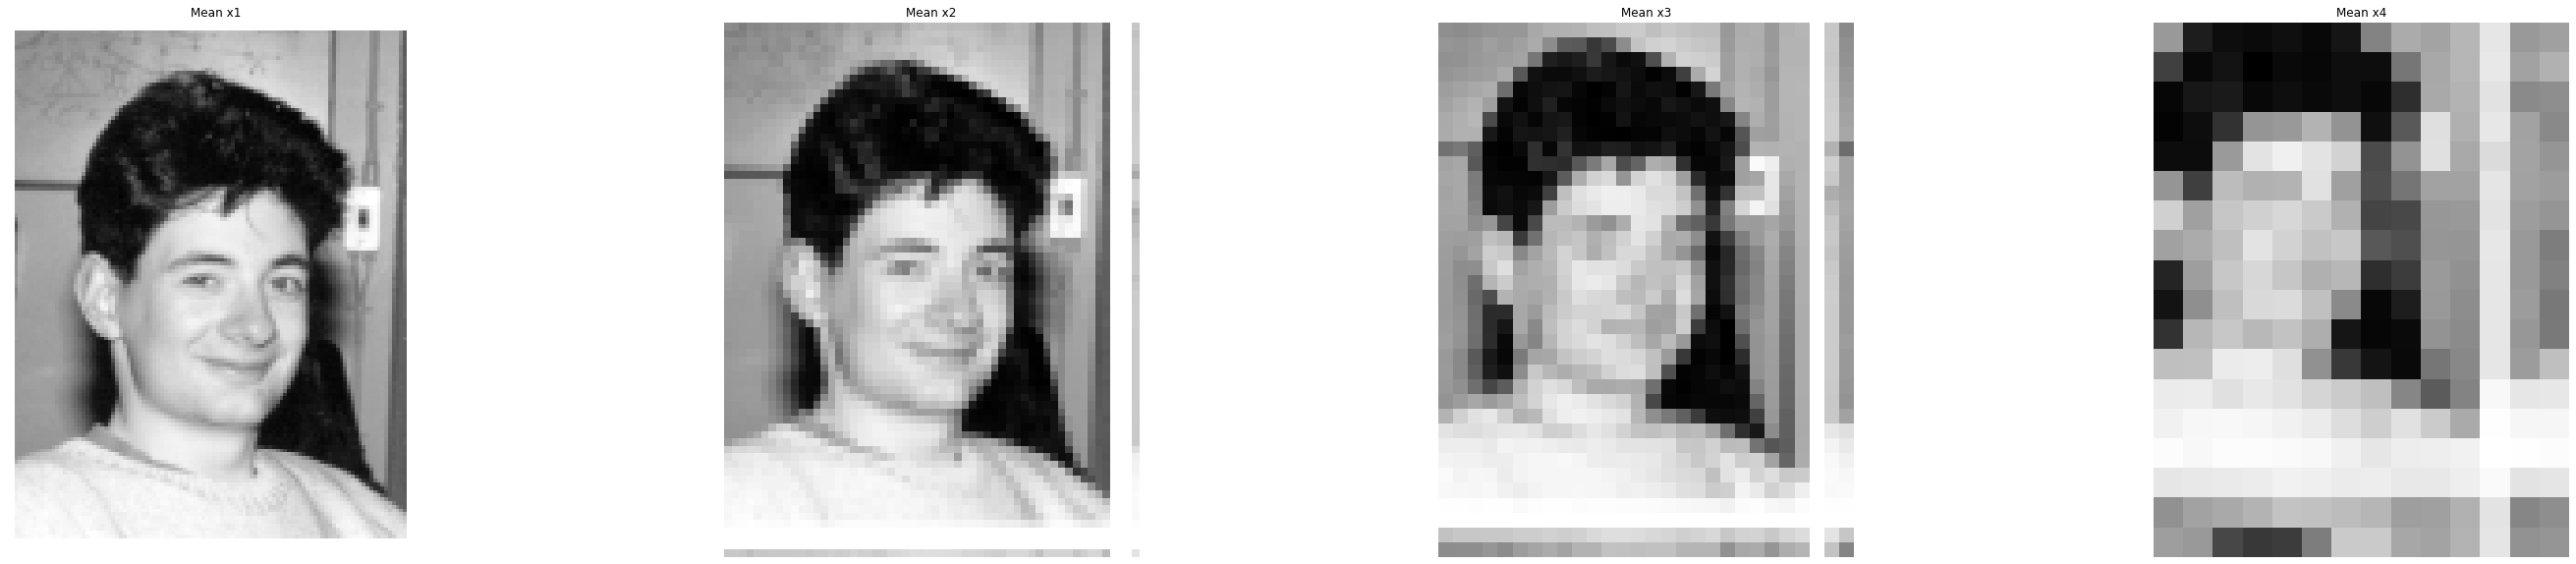

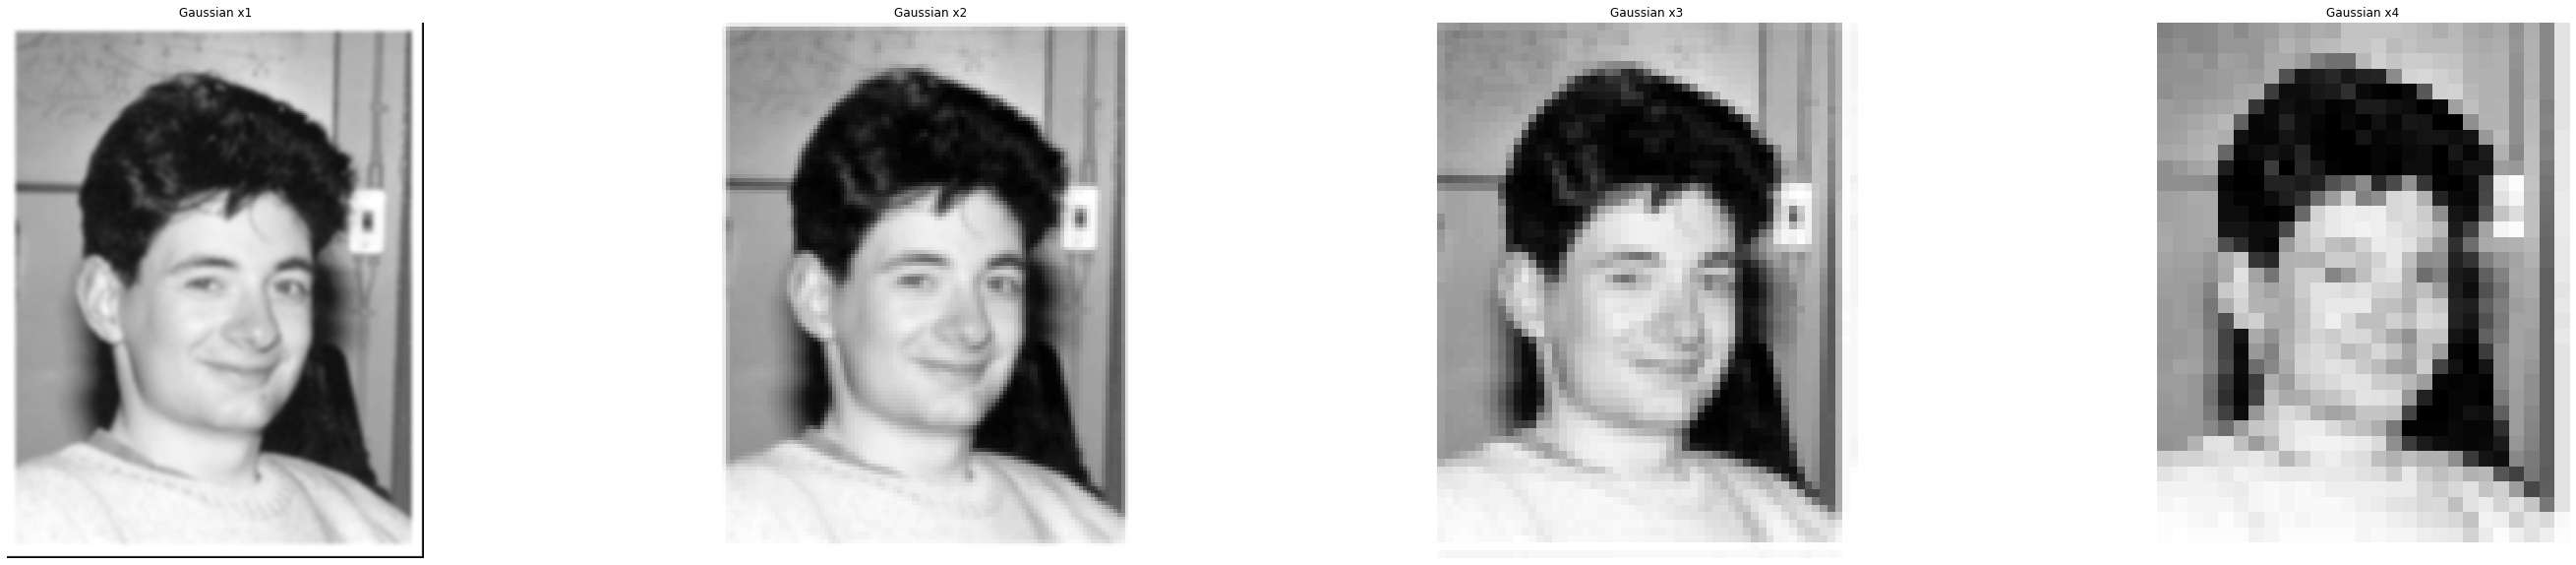

In [7]:
from operator import itemgetter
num=4
def downsample(image,scale=1):# two approaches for extra annoying pixels, 1-not taking them into,2- upscale then downsample by concatentating mod(n_columns,2**scale) and mod(n_rows,2**scale) remaining rows and columns 
    out=np.copy(image)
    extra_row=image[-1,::]
    extra_col=image[::,-1]
    out_downsample=np.zeros((int(np.ceil(out.shape[0]/2**scale)),int(np.ceil(out.shape[1]/2**scale))))
    #print(out.shape)
    #print(out_downsample.shape)
    if out.shape[0]%(2**scale)>0:
      for i in range(out.shape[0]%(2**scale)):
        out=np.vstack([out,extra_row.reshape(1,-1)])
        extra_row=out[-1,::]
        extra_col=out[::,-1]
    if out.shape[1]%(2**scale)>0:
      for i in range(out.shape[1]%(2**scale)):
        #print(out.shape,extra_col.shape)
        out=np.hstack([out,extra_col.reshape(-1,1)])
        extra_row=out[-1,::]
        extra_col=out[::,-1]
    for i in range(1,out.shape[0],2**scale):
      for j in range(1,out.shape[1],2**scale):
        val=int(np.round(np.mean(out[i:i+2,j:j+2].flatten())))
        #print(i,j,i/(2**scale),j/(2**scale))
        out_downsample[int(i/2**scale)-1,int(j/2**scale)-1]=val
    return out_downsample #:))
#plt.imshow(downsample(img,scale=3),cmap='gray'),plt.axis('off');
def mean_pyramid(image,scale):
  size=(50,10)
  fig=plt.figure(figsize=size)
  #print("Mean Pyramid")
  for i in range(scale):
    fig.add_subplot(1, scale,i+1)
    image=downsample(image,scale=1) # no need to set scale value
    plt.title("Mean x{}".format(i+1))
    plt.imshow(image,cmap='gray'),plt.axis('off');
mean_pyramid(img,num)
def gaussian_pyramid(image,scale):
  size=(50,10)
  fig=plt.figure(figsize=size)
  #print("Gaussian Pyramid")
  for i in range(scale):
    fig.add_subplot(1, scale,i+1)
    image=gaussian_kernel(image)
    plt.title("Gaussian x{}".format(i+1))
    plt.imshow(downsample(image,scale=i),cmap='gray'),plt.axis('off');
gaussian_pyramid(img,num)